In [76]:
library(IRdisplay)
display_html("<style>.container { width:100% !important; }</style>")

In [77]:
suppressPackageStartupMessages(library(SingleCellExperiment))
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(purrr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(optparse))
suppressPackageStartupMessages(library(MouseGastrulationData))
suppressPackageStartupMessages(library(assertthat))
suppressPackageStartupMessages(library(scran))
suppressPackageStartupMessages(library(batchelor))
suppressPackageStartupMessages(library(tools))
suppressPackageStartupMessages(library(stringr))

In [78]:
opts <- list()
opts$atlas.RDS <- "/nfs/research1/marioni/Leah/gastrulation10x/data/fromRpackage/sce_atlas.rds"
opts$atlas.metadata <- "/nfs/research1/marioni/Leah/gastrulation10x/data/fromRpackage/atlas_metadata.txt.gz"
opts$query.seurat <- "/nfs/research1/marioni/Leah/scNMTseq/ModelSystems/TettKOchimera/processed_files_Leah/seurat_QCed.rds"
opts$query.metadata <- "/nfs/research1/marioni/Leah/scNMTseq/ModelSystems/TettKOchimera/processed_files_Leah/sample_metadata_QCed.txt"
opts$query_batches <- "WT"
opts$settings <- "/nfs/research1/marioni/Leah/scNMTseq/ModelSystems/mapping_TetTKO/mapping/settings.R"
opts$functions <- "/nfs/research1/marioni/Leah/scNMTseq/ModelSystems/mapping_TetTKO/mapping/mapping_functions.R"

In [4]:
if (is.null(opts$query.seurat)){
    stop("The path to a query Seurat file must be supplied.n", call.=FALSE)
} else if (is.null(opts$query.metadata)){
    stop("The path to query sample metadata must be supplied.n", call.=FALSE)
} else if (is.null(opts$settings)) {
    stop("A settings file must be supplied.n", call.=FALSE)
} else if (is.null(opts$functions)) {
    stop("A functions file must be supplied.n", call.=FALSE)
} else if (((!is.null(opts$lineage.list)) || (!is.null(opts$lineage.name))) && (is.null(opts$query.mapping.RDS))) {
    stop("A path to a previous mapping output RDS file must be supplied.n", call.=FALSE)
} else if (((!is.null(opts$lineage.list)) || (!is.null(opts$lineage.name))) && (is.null(opts$query.mapping.meta))) {
    stop("A path to a previous mapping output metadata file must be supplied.n", call.=FALSE)
}

In [5]:
source(opts$settings)
source(opts$functions)

if ((!is.null(io$testing)) && (io$testing != TRUE)){
    stop("In the settings file, testing must be NULL or TRUE.n", call.=FALSE)
} else if ((!is.null(io$atlas.metadata)) && (!is.string(io$atlas.metadata))){
    stop("In the settings file, atlas.metadata must be NULL or a path.n", call.=FALSE)
} else if ((!is.null(io$atlas.RDS)) && (!is.string(io$atlas.RDS))){
    stop("In the settings file, atlas.RDS must be NULL or a path.n", call.=FALSE)
} else if ((!is.null(io$atlas_stages)) && (!is.string(io$atlas_stages))){
    stop("In the settings file, atlas_stages must be NULL or a path.n", call.=FALSE)
} else if ((!is.null(opts$lineage.name)) && (!opts$lineage.name %in% names(io$subset_celltypes))){
    stop("The lineage name must be the name of one of the settings file classes.n", call.=FALSE)
}

if (isTRUE(io$testing)) opts$testing = TRUE
if (is.string(io$atlas.RDS)) opts$atlas.RDS <- io$atlas.RDS
if (is.string(io$atlas.metadata)) opts$atlas.metadata <- io$atlas.metadata
if (is.string(io$atlas_stages)) opts$atlas_stages <- io$atlas_stages
if (is.null(opts$query_batches)) opts$query_batches = "all"
if (isTRUE(opts$testing)) message("Doing mapping in test mode (subsetting cells)...")

if (is.string(opts$query_batches)) opts$query_batches <- str_trim(strsplit(opts$query_batches, ",")[[1]])
if (is.string(opts$atlas_stages)) opts$atlas_stages <- str_trim(strsplit(opts$atlas_stages, ",")[[1]])
if (is.string(opts$lineage.list)) opts$lineage.list <- str_trim(strsplit(opts$lineage.list, ",")[[1]])
if (is.string(opts$lineage.name)) opts$lineage.list <- io$subset_celltypes[opts$lineage.name][[1]]


In [6]:
################
## Load atlas ##
################

message("Loading atlas...")

if ((is.null(opts$atlas.RDS)) || (is.null(opts$atlas.metadata))){
    
    message("Downloading atlas from bioconda package...")
    
    # Load SingleCellExperiment
    suppressMessages(sce_atlas <- EmbryoAtlasData(type="processed"))
    
    sce_atlas <- sce_atlas[,sce_atlas$doublet==F & sce_atlas$stripped==F]
    
    # Load metadata
    meta_atlas <- colData(sce_atlas) %>% as.data.table
    
} else {
    
    # Load metadata
    if (file_ext(opts$atlas.metadata) == "rds") {
        meta_atlas <- readRDS(paste0(opts$atlas.metadata)) %>% as.data.table
    } else {
        meta_atlas <- fread(opts$atlas.metadata, sep="\t", na="NA", quote=F) %>% as.data.table
    }
    
    meta_atlas <- meta_atlas[meta_atlas$doublet==FALSE,]
    meta_atlas <- meta_atlas[meta_atlas$stripped==FALSE,]
    
    # Load SingleCellExperiment
    sce_atlas  <- readRDS(paste0(opts$atlas.RDS))[,meta_atlas$cell]
}

# normalise atlas
sce_atlas <- scater::logNormCounts(sce_atlas)

# Filter stages
if (!is.null(opts$atlas_stages)) {
  message(sprintf("Subsetting atlas stages to %s",paste(opts$atlas_stages, collapse=", ")))
  meta_atlas <- meta_atlas[stage%in%opts$atlas_stages]
}

# Filter lineages
if (!is.null(opts$lineage.list)) {
  message(sprintf("Subsetting atlas to %s",paste(opts$lineage.list, collapse=", ")))
  meta_atlas <- meta_atlas[meta_atlas$celltype %in% opts$lineage.list]
}

# Filter if test mode
if (isTRUE(opts$testing)) {
    
    n <- round(10000/length(unique(meta_atlas$sample)))
    sub = c()
    for (s in unique(meta_atlas$sample)){
        sub <- append(sub, meta_atlas[meta_atlas$sample==s,]$cell[1:n])
    }
    
    meta_atlas <- meta_atlas[meta_atlas$cell %in% sub,]; rm(sub)
}


sce_atlas <- sce_atlas[,meta_atlas$cell]
stopifnot(all(meta_atlas$cell == colnames(sce_atlas)))

Loading atlas...



In [7]:
################
## Load query ##
################

message("Loading query...")

# Load metadata
meta_query <- fread(paste0(opts$query.metadata)) 

# Filter batches
if (any(opts$query_batches != "all")) {
  message(sprintf("Subsetting query batches to %s",paste(opts$query_batches, collapse=", ")))
  meta_query <- meta_query[genotype%in%opts$query_batches]
}

# Filter lineages
if (!is.null(opts$lineage.list)) {
  message(sprintf("Subsetting query to %s",paste(opts$lineage.list, collapse=", ")))
  meta_map <- fread(opts$query.mapping.meta)
  meta_map <- meta_map[meta_map$celltype.mapped %in% opts$lineage.list]
  meta_query <- merge(meta_query, meta_map, by=c(colnames(meta_query)))
}

# Filter if test mode
if (isTRUE(opts$testing)) {
    
    n <- round(1000/length(opts$query_batches))
    sub = c()
    for (b in opts$query_batches){
        sub <- append(sub, meta_query[meta_query$genotype==b,]$cell[1:n])
    }
    
    meta_query <- meta_query[meta_query$cell %in% sub,]
}

# Load SingleCellExperiment
sce_query <- Seurat::as.SingleCellExperiment( readRDS(paste0(opts$query.seurat))[,meta_query$cell] )

stopifnot(all(meta_query$cell == colnames(sce_query)))

Loading query...

Subsetting query batches to WT



In [81]:
meta_atlas <- fread(opts$atlas.metadata, sep="\t", na="NA", quote=F) %>% as.data.table

In [82]:
head(meta_atlas)

cell,barcode,sample,pool,stage,sequencing.batch,theiler,doub.density,doublet,cluster,cluster.sub,cluster.stage,cluster.theiler,stripped,celltype,colour
<chr>,<chr>,<int>,<int>,<chr>,<int>,<chr>,<dbl>,<lgl>,<int>,<int>,<int>,<int>,<lgl>,<chr>,<chr>
cell_1,AAAGGCCTCCACAA,1,1,E6.5,1,TS9,0.04311420,FALSE,2,4,2,3,FALSE,Epiblast,635547
cell_2,AACAAACTCGCCTT,1,1,E6.5,1,TS9,1.12971326,FALSE,12,1,1,1,FALSE,Primitive Streak,DABE99
cell_3,AACAATACCCGTAA,1,1,E6.5,1,TS9,0.00000000,FALSE,NA,NA,NA,NA,TRUE,NA,NA
cell_4,AACACTCTCATTCT,1,1,E6.5,1,TS9,0.08468852,FALSE,NA,NA,NA,NA,TRUE,NA,NA
cell_5,AACAGAGAATCAGC,1,1,E6.5,1,TS9,0.11212055,FALSE,3,7,4,6,FALSE,ExE ectoderm,989898
cell_6,AACATATGAATCGC,1,1,E6.5,1,TS9,1.25470878,FALSE,1,1,3,7,FALSE,Epiblast,635547


In [79]:
meta_query

orig.ident,nCount_RNA,nFeature_RNA,barcode,genotype,batch,cell,stage,origrn
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
cell,1281,715,AAACCCAAGACGAGCT-1,WT,SIGAA3_E8.5_pool1_Host-WT_L001,cell_1,E8.5,cell_1
cell,1329,700,AAACCCAAGACTTCAC-1,WT,SIGAA3_E8.5_pool1_Host-WT_L001,cell_2,E8.5,cell_2
cell,1332,725,AAACCCAAGAGGATGA-1,WT,SIGAA3_E8.5_pool1_Host-WT_L001,cell_3,E8.5,cell_3
cell,1299,702,AAACCCAAGTGAACAT-1,WT,SIGAA3_E8.5_pool1_Host-WT_L001,cell_7,E8.5,cell_7
cell,1263,678,AAACGAACAGTAGAAT-1,WT,SIGAA3_E8.5_pool1_Host-WT_L001,cell_24,E8.5,cell_24
cell,1287,707,AAACGAATCCTGTACC-1,WT,SIGAA3_E8.5_pool1_Host-WT_L001,cell_33,E8.5,cell_33
cell,1889,1037,AAACGAATCGTTCCTG-1,WT,SIGAA3_E8.5_pool1_Host-WT_L001,cell_35,E8.5,cell_35
cell,1510,765,AAACGCTAGGATACGC-1,WT,SIGAA3_E8.5_pool1_Host-WT_L001,cell_38,E8.5,cell_38
cell,1348,719,AAACGCTAGGATCATA-1,WT,SIGAA3_E8.5_pool1_Host-WT_L001,cell_39,E8.5,cell_39


In [71]:
meta_query <- fread(paste0(opts$query.metadata))
meta_query[,.N,by=c("batch")]

batch,N
<chr>,<int>
SIGAA3_E8.5_pool1_Host-WT_L001,2698
SIGAC3_E8.5_pool2_Host-WT_L003,10495
SIGAE3_E7.5_pool1_Host-WT_L005,2465
SIGAG3_E8.5_hashing_Host-WT_L007,11487
SIGAB3_E8.5_pool1_TET-TKO_L002,101
SIGAD3_E8.5_pool2_TET-TKO_L004,78
SIGAF3_E7.5_pool1_TET-TKO_L006,77
SIGAH3_E8.5_hasting_TET-TKO_L008,1311


In [72]:
io$order <- list()
io$order[["WT"]] <- c("ATLAS", "SIGAG3_E8.5_hashing_Host-WT_L007", "SIGAC3_E8.5_pool2_Host-WT_L003", "SIGAA3_E8.5_pool1_Host-WT_L001", "SIGAE3_E7.5_pool1_Host-WT_L005")
io$order[["TKO"]] <- c("ATLAS", "SIGAH3_E8.5_hasting_TET-TKO_L008", "SIGAB3_E8.5_pool1_TET-TKO_L002", "SIGAD3_E8.5_pool2_TET-TKO_L004", "SIGAF3_E7.5_pool1_TET-TKO_L006")

In [75]:
io$order[[opts$query_batches]]

[1] "ATLAS"                            "SIGAG3_E8.5_hashing_Host-WT_L007"
[3] "SIGAC3_E8.5_pool2_Host-WT_L003"   "SIGAA3_E8.5_pool1_Host-WT_L001"  
[5] "SIGAE3_E7.5_pool1_Host-WT_L005"

'SIGAA3_E8.5_pool1_Host-WT_L001''SIGAB3_E8.5_pool1_TET-TKO_L002''SIGAC3_E8.5_pool2_Host-WT_L003''SIGAD3_E8.5_pool2_TET-TKO_L004''SIGAE3_E7.5_pool1_Host-WT_L005''SIGAF3_E7.5_pool1_TET-TKO_L006''SIGAG3_E8.5_hashing_Host-WT_L007''SIGAH3_E8.5_hasting_TET-TKO_L008'

In [8]:
#####################
## Intersect genes ## 
#####################

message("Filtering genes...")

# Remove genes with low expression in both query and atlas
tmp1 <- rowSums(counts(sce_atlas)); tmp1 <- tmp1[tmp1>=io$min.counts.per.gene]
tmp2 <- rowSums(counts(sce_query)); tmp2 <- tmp2[tmp2>=io$min.counts.per.gene]

genes <- intersect(names(tmp1), names(tmp2))
sce_query  <- sce_query[genes,]
sce_atlas <- sce_atlas[genes,]

Filtering genes...



In [9]:
#########
## Map ##
#########

atlas_sce <- sce_atlas; rm(sce_atlas)
atlas_meta <- meta_atlas; rm(meta_atlas)
map_sce <- sce_query; rm(sce_query)
map_meta <- meta_query; rm(meta_query)
order <- io$order[[opts$query_batches]]
k <- io$k; io$k <- NULL
npcs <- io$npcs; io$npcs <- NULL

In [10]:
message("Normalizing joint dataset...")

#easier to avoid directly binding sce objects as it is a lot more likely to have issues
sce_all <- SingleCellExperiment::SingleCellExperiment(
list(counts=Matrix::Matrix(cbind(counts(atlas_sce),counts(map_sce)),sparse=TRUE)))
#big_sce <- scater::normalize(sce_all)
#big_sce <- scater::logNormCounts(sce_all) # edited 09.02.2020 because normalize deprecated in favour of logNormCounts
big_sce <- multiBatchNorm(sce_all, batch=c(atlas_meta$sample, map_meta$batch)) # edited 17.02.2020 because now multibatchnorm exists
message("Done\n")

Normalizing joint dataset...

Done




In [11]:
message("Computing highly variable genes...")
hvgs    <- getHVGs(big_sce, block=c(atlas_meta$sample, map_meta$batch))
message(length(hvgs))
message("Done\n")

Computing highly variable genes...

3811

Done




In [12]:
message("Performing PCA...")
big_pca <- multiBatchPCA(big_sce, batch=c(atlas_meta$sample, map_meta$batch), subset.row = hvgs, d = npcs, preserve.single = TRUE, assay.type = "logcounts")[[1]]
rownames(big_pca) <- colnames(big_sce) 
atlas_pca <- big_pca[1:ncol(atlas_sce),]
map_pca   <- big_pca[-(1:ncol(atlas_sce)),]
message("Done\n")

Performing PCA...

Warning message in sweep(centered, 2, w, "/", check.margin = FALSE):
“'check.margin' is ignored when 'x' is a DelayedArray object or
  derivative”
Done




In [13]:
message("Batch effect correction for the atlas...")  
order_df        <- atlas_meta[!duplicated(atlas_meta$sample), c("stage", "sample")]
order_df$ncells <- sapply(order_df$sample, function(x) sum(atlas_meta$sample == x))
order_df$stage  <- factor(order_df$stage, 
                        levels = rev(c("E8.5","E8.25","E8.0","E7.75","E7.5","E7.25","mixed_gastrulation","E7.0","E6.75","E6.5")))
order_df       <- order_df[order(order_df$stage, order_df$ncells, decreasing = TRUE),]
order_df$stage <- as.character(order_df$stage)

set.seed(42)
atlas_corrected <- doBatchCorrect(counts         = logcounts(atlas_sce[hvgs,]), 
                                timepoints      = atlas_meta$stage, 
                                samples         = atlas_meta$sample, 
                                timepoint_order = order_df$stage, 
                                sample_order    = order_df$sample, 
                                pc_override     = atlas_pca,
                                npc             = npcs)
message("Done\n")

Batch effect correction for the atlas...

Done




In [26]:
tmp <- rbind(atlas_corrected, map_pca)

In [23]:
batch <- c(rep("ATLAS", dim(atlas_meta)[1]), map_meta$batch)
length(batch)

[1] 143457

In [20]:
unique(batch)

[1] "ATLAS"                            "SIGAA3_E8.5_pool1_Host-WT_L001"  
[3] "SIGAC3_E8.5_pool2_Host-WT_L003"   "SIGAE3_E7.5_pool1_Host-WT_L005"  
[5] "SIGAG3_E8.5_hashing_Host-WT_L007"

In [18]:
map_meta[,.N,by=c("batch")]

batch,N
<chr>,<int>
SIGAA3_E8.5_pool1_Host-WT_L001,2698
SIGAC3_E8.5_pool2_Host-WT_L003,10495
SIGAE3_E7.5_pool1_Host-WT_L005,2465
SIGAG3_E8.5_hashing_Host-WT_L007,11487


In [30]:
correct <- reducedMNN(rbind(atlas_corrected, map_pca),
                      batch=c(rep("ATLAS", dim(atlas_meta)[1]), map_meta$batch),
                      merge.order=c("ATLAS", "SIGAG3_E8.5_hashing_Host-WT_L007", "SIGAC3_E8.5_pool2_Host-WT_L003", "SIGAA3_E8.5_pool1_Host-WT_L001", "SIGAE3_E7.5_pool1_Host-WT_L005"))$corrected

In [31]:
suppressPackageStartupMessages(library(umap))
message("Running UMAP...")
# calculate joint UMAP
UMAP_joined <- umap(correct, method='umap-learn')

Running UMAP...



In [53]:
atlas_meta$map <- "ATLAS"
map_meta$map <- "QUERY"
meta_joined <- rbind.fill(atlas_meta, map_meta)
tmp <- data.frame(UMAP_joined$layout)
plot_df_joined <- cbind(tmp, meta_joined)
plot_df_atlas <- plot_df_joined[plot_df_joined$map=="ATLAS",]
plot_df_query <- plot_df_joined[plot_df_joined$map=="QUERY",]

In [58]:
celltype_colours = c(
 "Epiblast" = "#635547",
 "Primitive Streak" = "#DABE99",
 "Caudal epiblast" = "#9e6762",
 "PGC" = "#FACB12",
 "Anterior Primitive Streak" = "#c19f70",
 "Notochord" = "#0F4A9C",
 "Def. endoderm" = "#F397C0",
 "Gut" = "#EF5A9D",
 "Nascent mesoderm" = "#C594BF",
 "Mixed mesoderm" = "#DFCDE4",
 "Intermediate mesoderm" = "#139992",
 "Caudal Mesoderm" = "#3F84AA",
 "Paraxial mesoderm" = "#8DB5CE",
 "Somitic mesoderm" = "#005579",
 "Pharyngeal mesoderm" = "#C9EBFB",
 "Cardiomyocytes" = "#B51D8D",
 "Allantois" = "#532C8A",
 "ExE mesoderm" = "#8870ad",
 "Mesenchyme" = "#cc7818",
 "Haematoendothelial progenitors" = "#FBBE92",
 "Endothelium" = "#ff891c",
 "Blood progenitors 1" = "#f9decf",
 "Blood progenitors 2" = "#c9a997",
 "Erythroid1" = "#C72228",
 "Erythroid2" = "#f79083",
 "Erythroid3" = "#EF4E22",
 "NMP" = "#8EC792",
 "Rostral neurectoderm" = "#65A83E",
 "Caudal neurectoderm" = "#354E23",
 "Neural crest" = "#C3C388",
 "Forebrain/Midbrain/Hindbrain" = "#647a4f",
 "Spinal cord" = "#CDE088",
 "Surface ectoderm" = "#f7f79e",
 "Visceral endoderm" = "#F6BFCB",
 "ExE endoderm" = "#7F6874",
 "ExE ectoderm" = "#989898",
 "Parietal endoderm" = "#1A1A1A"
)

barplot.pub <- function(to.plot, x="lineage10x_2", colors=NULL, xlim.max=NULL) {
  p <- ggplot(to.plot, aes_string(x=x, y="N")) +
    scale_x_discrete(drop=FALSE) + 
    # coord_flip() +
    labs(y="Number of cells") +
    theme_classic() +
    theme(
      legend.position = "none",
      strip.background = element_blank(),
      strip.text = element_text(color="black", size=rel(1.3)),
      axis.title.x = element_text(color="black", size=rel(1.1)),
      axis.title.y = element_blank(),
      axis.text.y = element_text(size=rel(1.3), color="black"),
      axis.text.x = element_text(size=rel(1.1), color="black")
    )
    
    if (is.null(colors)) {
        p <- p + geom_bar(stat="identity", color="black")
    } else {
        p <- p + geom_bar(aes_string(fill=x), stat="identity", color="black") + 
            scale_fill_manual(values=colors, drop=F)
    }

    if (!is.null(xlim.max)) {
      p <- p + coord_flip(ylim=c(0,xlim.max))
    } else {
      p <- p + coord_flip()
    }
  
    return(p)
}

stage_colours <- c("E6.5" = "#D53E4F",
                   "E6.75" = "#F46D43",
                   "E7.0" = "#FDAE61",
                   "E7.25" = "#FEE08B",
                   "E7.5" = "#FFFFBF",
                   "E7.75" = "#E6F598",
                   "E8.0" = "#ABDDA4",
                   "E8.25" = "#66C2A5",
                   "E8.5" = "#3288BD",
                   "mixed_gastrulation" = "#A9A9A9")

sample_colours <- c("ESC" = "#635547",
                    "nomap" = "gray",
                    "EB_d3" = "#cfd9e4",
                    "EB_d4" = "#88a1bc",
                    "EB_d5" = "#406993",
                    "EB_d6" = "#2e4660",
                    "gastr.d3" = "#88bc88",
                    "gastr.d4" = "#409341",
                    "MPP_d2" = "#bc88bb",
                    "MPP_d3" = "#934092",
                    "MPA_d2" = "#c28873",
                    "MPA_d3" = "#ae664c"
                    )


# Dot size
io$size.mapped <- 0.6
io$size.nomapped <- 0.1
# for atlas only
io$dot_size = 0.6

# Transparency
io$alpha.mapped <- 1.0
io$alpha.nomapped <- 0.5
# for atlas only
io$dot_alpha = 1

io$plot.type <- "pdf" # NULL or one of "eps", "ps", "tex" (pictex), "pdf", "jpeg", "tiff", "png", "bmp", "svg"

Plotting...



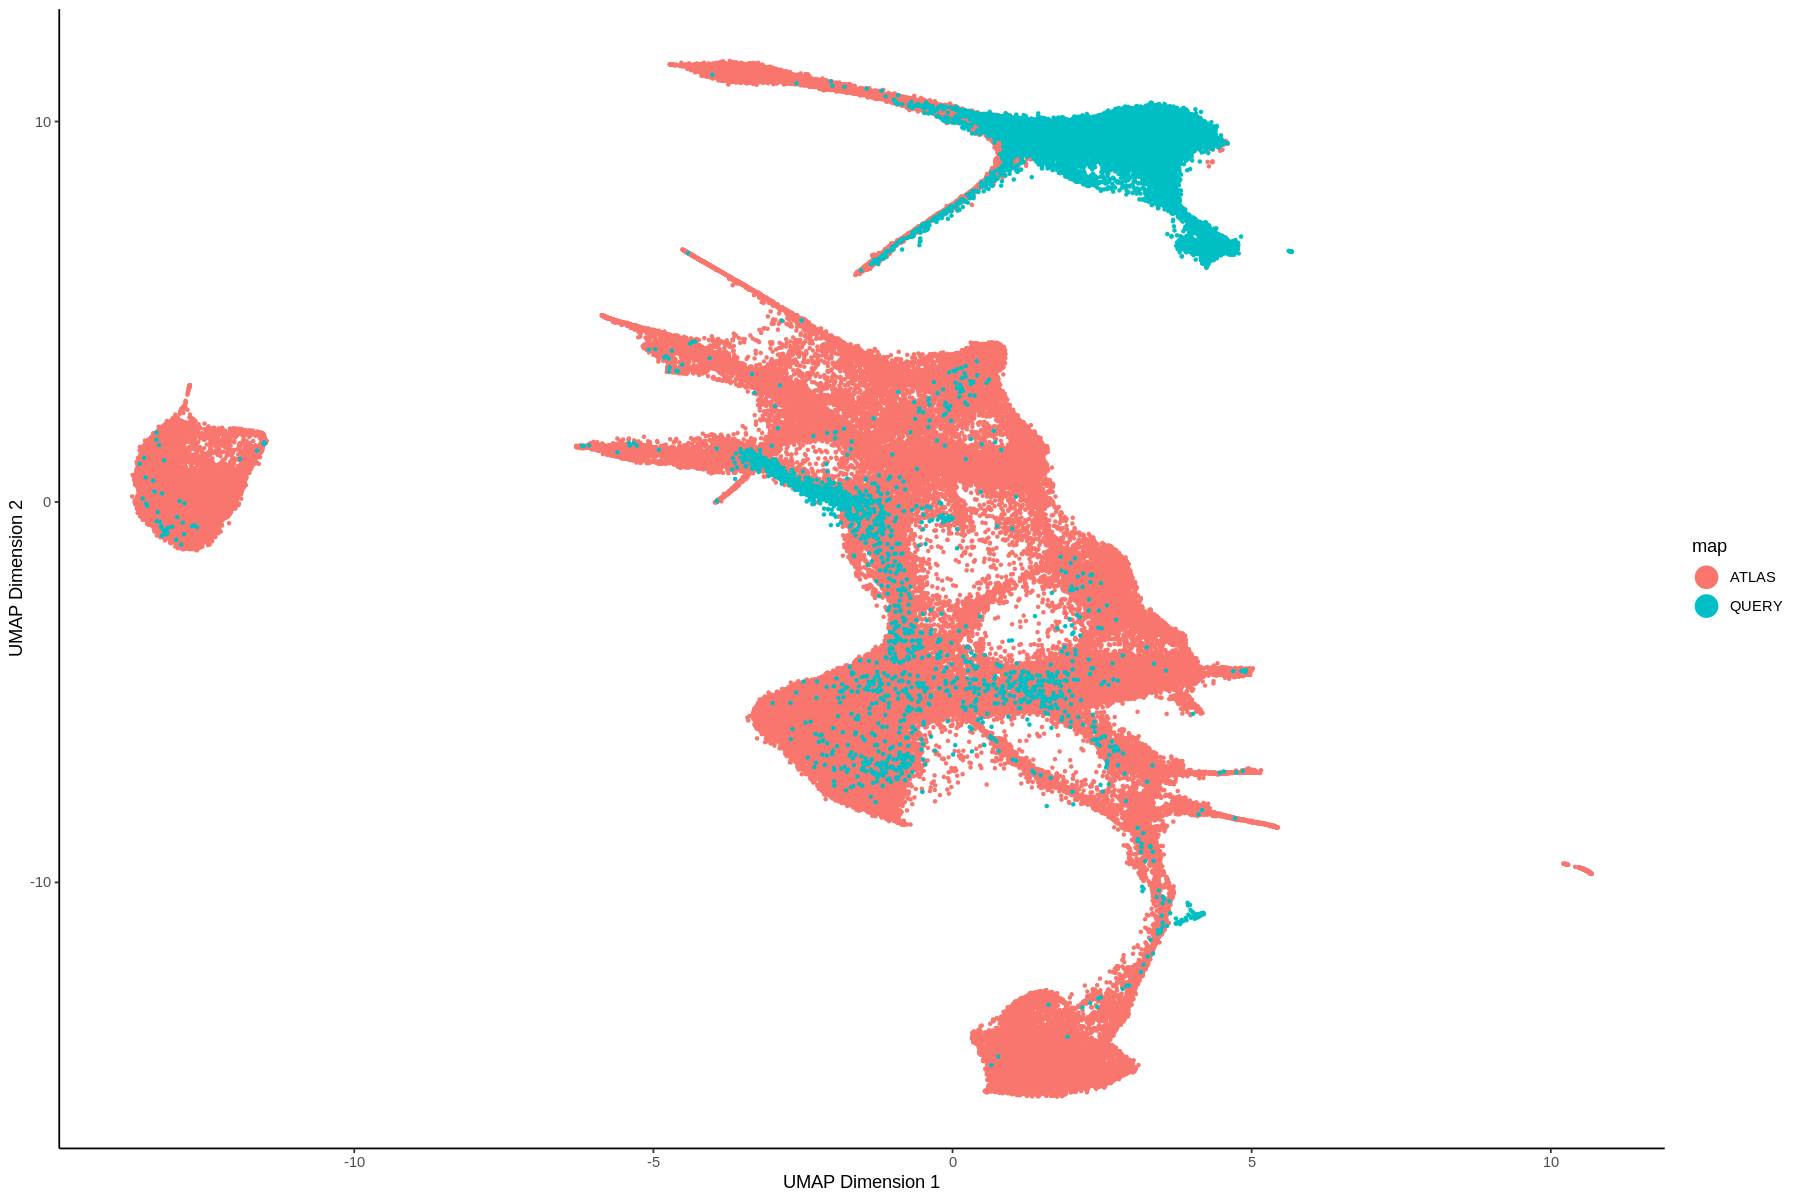

In [64]:
options(repr.plot.width=15, repr.plot.height=10)
message("Plotting...")
joint_map <- ggplot(data=plot_df_joined, mapping = aes(x=X1, y=X2, colour=map)) +
  geom_point(size=io$dot_size, alpha=io$dot_alpha) +
  # ggrastr::geom_point_rast(size=io$dot_size, alpha=io$dot_alpha) +
  labs(x="UMAP Dimension 1", y="UMAP Dimension 2") +
  guides(colour = guide_legend(override.aes = list(size=6))) +
  theme_classic()
print(joint_map)

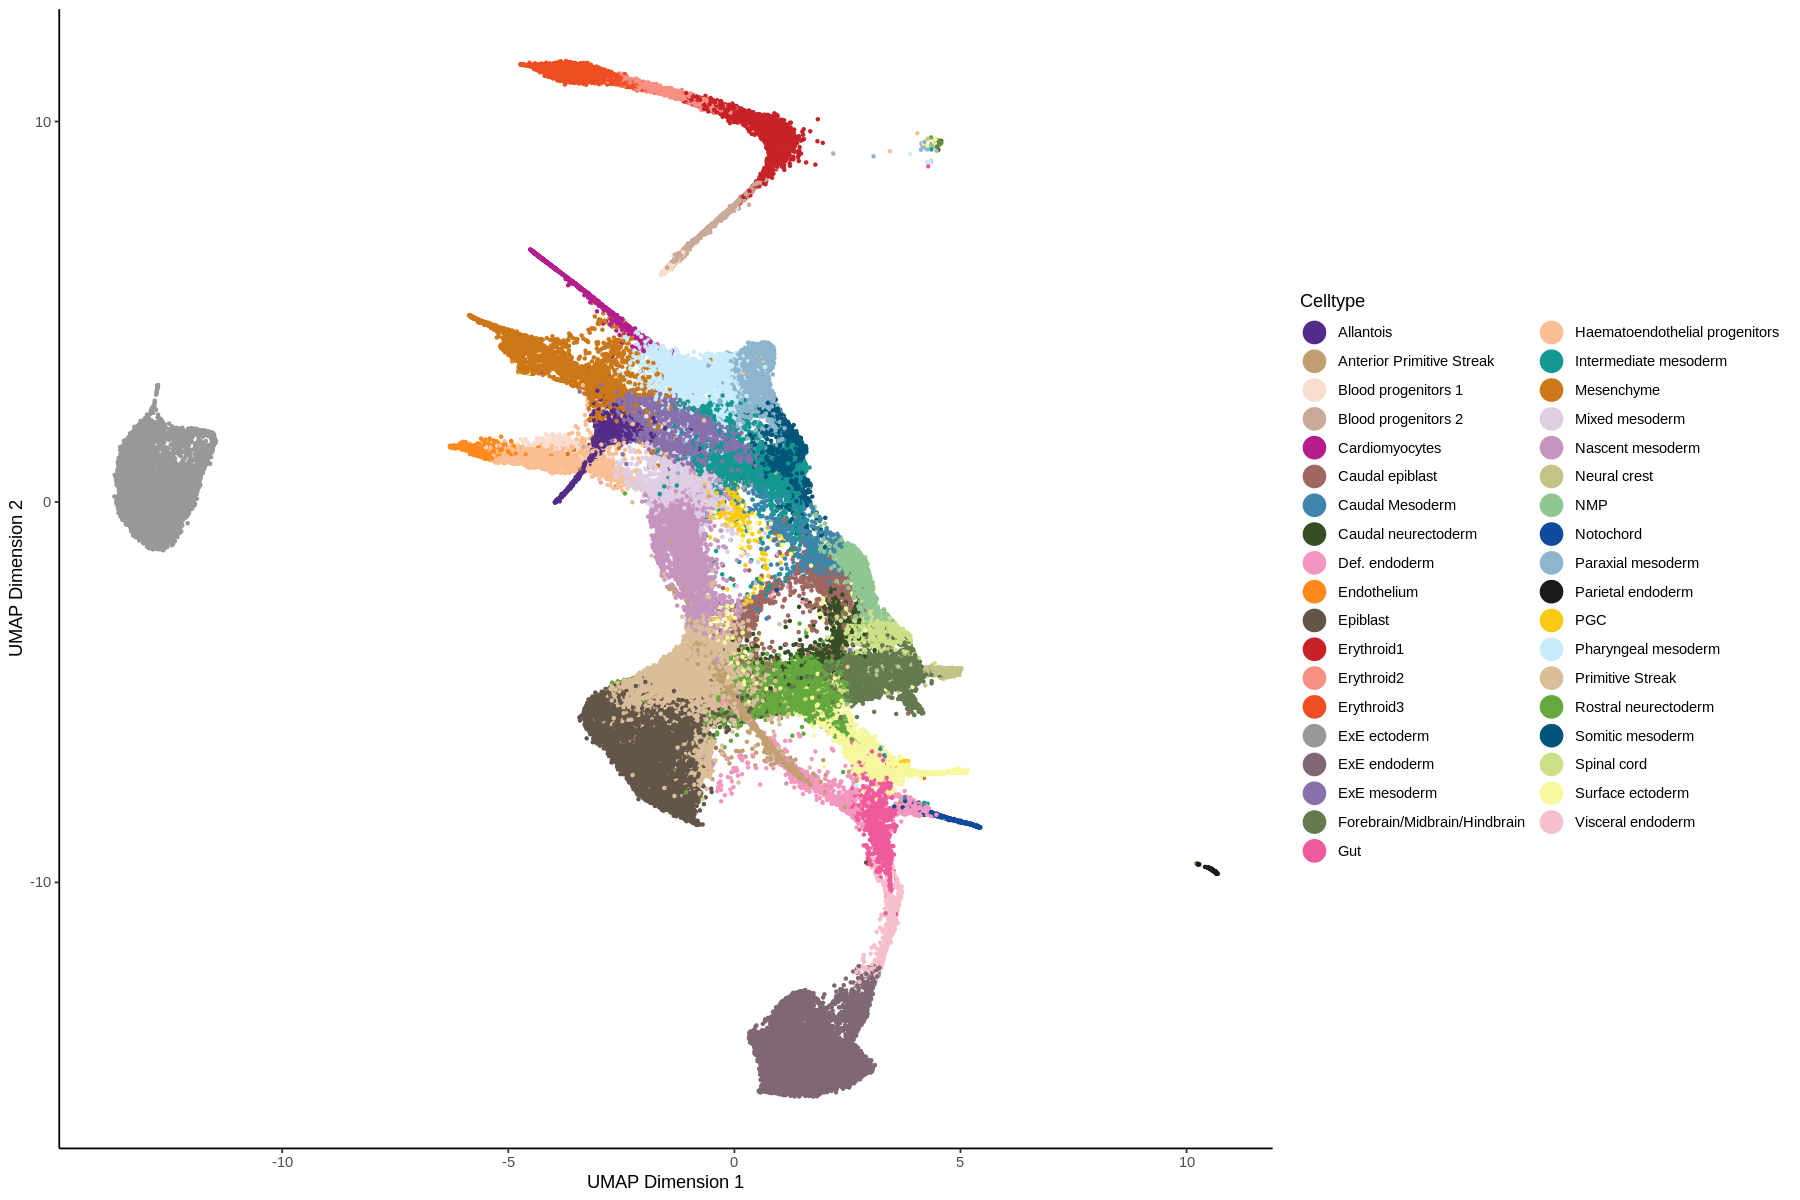

In [67]:
options(repr.plot.width=15, repr.plot.height=10)
atlas_celltype <- ggplot(data=plot_df_atlas, mapping = aes(x=X1, y=X2, colour=celltype)) +
  geom_point(size=io$dot_size, alpha=io$dot_alpha) +
  # ggrastr::geom_point_rast(size=opts$dot_size, alpha=opts$dot_alpha) +
  labs(x="UMAP Dimension 1", y="UMAP Dimension 2") +
  scale_colour_manual(values = celltype_colours, name = "Celltype") +
  guides(colour = guide_legend(override.aes = list(size=6))) +
  theme_classic()
print(atlas_celltypetype)

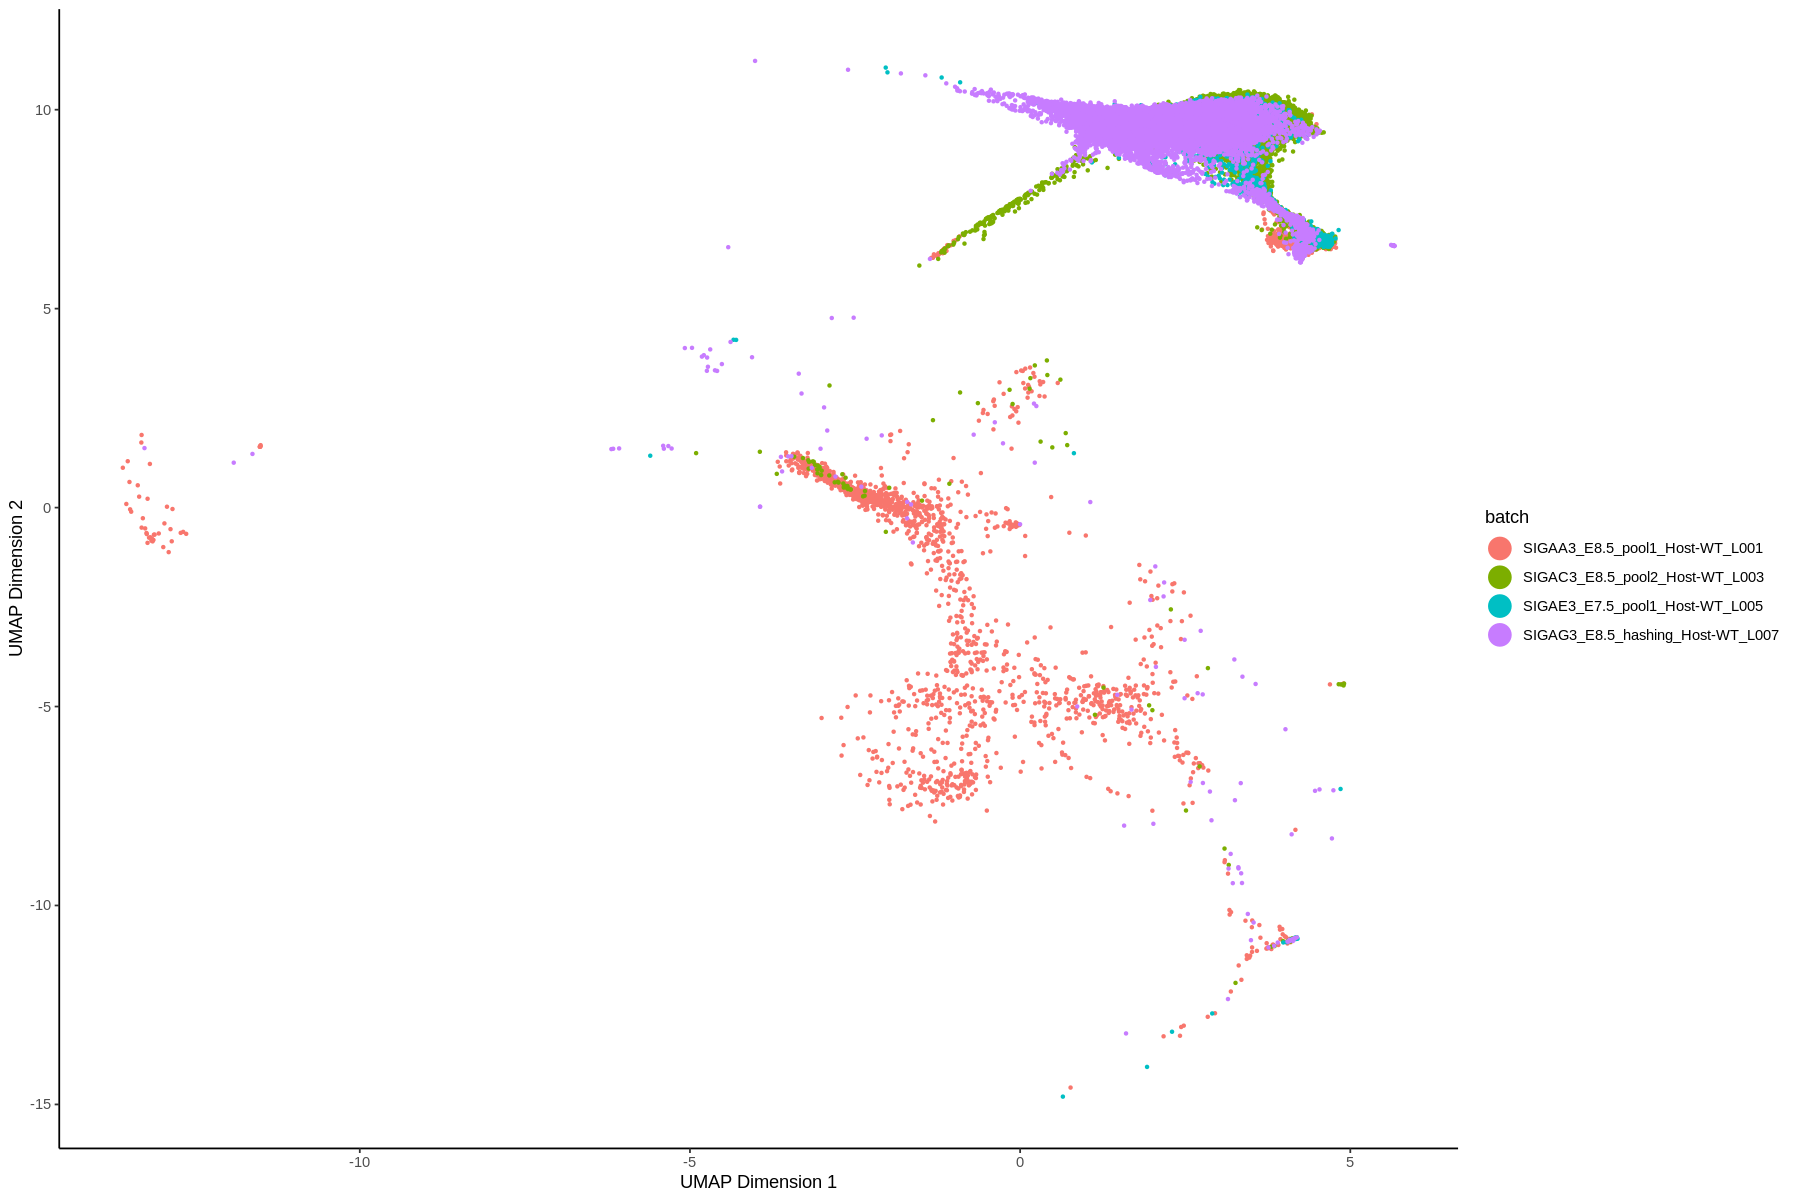

In [70]:
query_batch <- ggplot(data=plot_df_query, mapping = aes(x=X1, y=X2, colour=batch)) +
  geom_point(size=io$dot_size, alpha=io$dot_alpha) +
  # ggrastr::geom_point_rast(size=io$dot_size, alpha=io$dot_alpha) +
  labs(x="UMAP Dimension 1", y="UMAP Dimension 2") +
  guides(colour = guide_legend(override.aes = list(size=6))) +
  theme_classic()
print(query_batch)

# NOTE: INCLUDE THAT BATCH WHICH INCLUDES THE OLDEST QUERY THING IS MERGED FIRST

In [ ]:
message("MNN mapping...")
correct <- reducedMNN(rbind(atlas_corrected, map_pca),
                      batch=c(rep("ATLAS", dim(atlas_meta)[1]), map_meta$batch),
                      merge.order=order)$corrected
atlas   <- 1:nrow(atlas_pca)
correct_atlas <- correct[atlas,]
correct_map   <- correct[-atlas,]
mapping <- get_meta(correct_atlas = correct_atlas,
                  atlas_meta = atlas_meta,
                  correct_map = correct_map,
                  map_meta = map_meta,
                  k_map = k)
message("Done\n")